16/09/2023
# SIMULACIÓN DE EVOLUCIÓN DE UNA CARTERA DE ACTIVOS

La evolución de una cartera de acivos depende tanto de los rendimientos de los activos que la componen como de la matriz de varianzas y covarianzas de los rendimientos de los activos. 

Las correlaciones entre diferentes activos son fundamentales para entender cómo se comporta una cartera en diversas condiciones del mercado. Si ignoramos estas correlaciones al generar números aleatorios independientes para los retornos de los activos, no reflejaremos adecuadamente cómo se mueven juntos los activos en la cartera.

Por lo tanto, las técnicas de simulación de carteras suelen incorporar de manera cuidadosa la dependencia entre activos y las relaciones de correlación para obtener resultados más precisos.

En este notebook se muestra cómo simular la evolución de una cartera de activos generando números aleatorios que incorporen la dependencia entre activos. Los pasos van a ser:

1- Generación de números aleatorios independientes. Se usarán distribuiones marginales normales, t-student etc

2- Generación de números aleatorios siguiendo las relaciones de correlación entre activos de una cartera. Se usarán distribuiones marginales normales, t-student etc

3- Generción de números aleatorios que sigan una distribución 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats
import matplotlib.patches as patches

from utils import dibuja_covar, dibuja_covar_ax


## 1- Generación de números aleatorios independientes

Lo primero vamos a ver qué ocurre cuando generamos los números aleatorios usando las librerías de numpy. 

En este caso usamos una distribución normal estándar para generar los retornos de cada uno de los activos

In [6]:
num_act = 8 # number of assets
num_datos = 6000 # number of data points

rs = np.random.RandomState(seed=123) # Here we create like a session of random numbers that allows to reproduce the results

# We create a random matrix of returns
# The matrix is num_datos x num_act
samp_ind = rs.randn(num_datos, num_act) # a sample from independent standard normal distribution

corr_ind = np.corrcoef(samp_ind, rowvar=False) # correlation of the independent sample

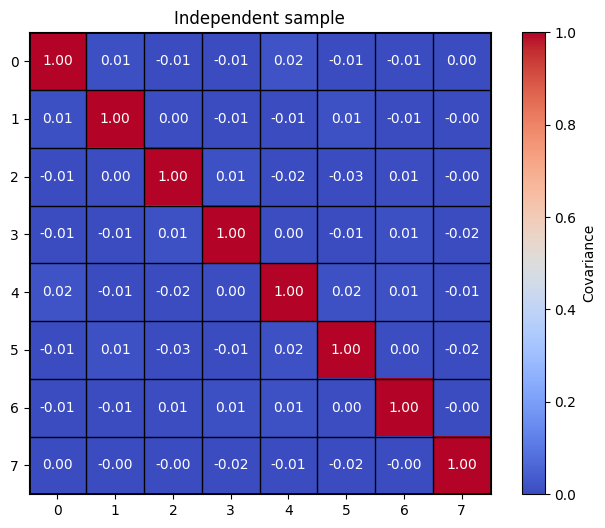

0

In [3]:
dibuja_covar(corr_ind, 'Independent sample')

## 2- Generarción Números Aleatorios Correlacionados

Basado en: https://financioneroncios.wordpress.com/2019/01/24/montecarlo-i/

Para generar los retornos de los activos de manera que mantengan las relaciones de los retornos reales, vamos a emplear dos herramientas:

1- **Cópulas**

2- **Descomposición de Cholesky**

**1- CÓPULA**

Una *cópula* es una función matemática que se utiliza en estadísticas para describir cómo se relacionan las distribuciones marginales de dos o más variables aleatorias y su dependencia conjunta, de manera independiente de las distribuciones individuales.

En otras palabras, una copula captura la estructura de dependencia entre variables sin preocuparse por las distribuciones específicas de cada una. Se utiliza para modelar y medir la dependencia estadística entre variables de manera más flexible y generalizada

En el mundo de las finanzas, las cópulas son herramientas importantes para modelar la dependencia entre activos financieros y calcular riesgos de cartera. A continuación, te menciono algunos ejemplos de cópulas utilizadas para este propósito:

1- *Cópula Gaussiana (Cópula Normal)*: Esta cópula asume que las distribuciones marginales de los activos son normales y modela la dependencia lineal entre ellos. Es ampliamente utilizada en el modelado de riesgo financiero, pero puede subestimar la cola de eventos extremos.

2- *Cópula t-Student*: Esta cópula es una extensión de la cópula Gaussiana que tiene en cuenta una mayor flexibilidad en las colas de las distribuciones marginales. Es útil cuando se espera que los activos tengan colas más gruesas.

3- *Cópula Clayton*: Esta cópula es adecuada para modelar eventos extremos y dependencia positiva. Se utiliza cuando se sospecha que la dependencia es más fuerte en los valores más altos.

4- *Cópula Gumbel*: Esta cópula es útil para modelar eventos extremos y dependencia positiva. Es una opción popular para calcular riesgos financieros en seguros y finanzas.



**2- DESCOMPOSICIÓN DE CHOLENSKY**.

La *descomposición de Cholesky* es una técnica que se utiliza para generar números aleatorios correlacionados de manera sencilla y efectiva. Aquí te explico cómo se hace:

1- Primero, necesitas tener una matriz de correlación que describa cómo están relacionadas las variables aleatorias. Esta matriz debe ser simétrica y positiva definida. Una matriz de correlaciones de los activos de una cartera es un ejemplo de este tipo de matriz.

2- Luego, aplicas la descomposición de Cholesky a esa matriz de correlación. Esta descomposición te dará otra matriz llamada $L$.

3- La matriz $L$ es triangular inferior y tiene la propiedad de que si la multiplicas por su traspuesta ($L^T$, la matriz transpuesta de $L$), obtendrás la matriz de correlación original. Es decir, $$L * L^T = Matriz\quad de\quad  Correlación$$

4- Ahora, puedes generar números aleatorios independientes y estándar (con media 0 y desviación estándar 1), por ejemplo, utilizando una distribución normal estándar.

5- Multiplicas estos números aleatorios por la matriz $L$.

6- Los números resultantes serán números aleatorios correlacionados que siguen la estructura de correlación deseada y con la distribución que hayas usado en el paso 4. Es decir, tendrán la misma relación entre sí que la matriz de correlación original.

En resumen, la descomposición de Cholesky te permite tomar números aleatorios independientes y transformarlos de manera que tengan la correlación que deseas, siguiendo la estructura definida por la matriz de correlación. Esto es útil en simulaciones y análisis donde necesitas generar números aleatorios que reflejen una cierta dependencia entre variables.







### Primer paso

Nos bajamos datos de precios históricos de algunos activos y vemos sus rendimientos y covarianzas. 

El objetivo final es generar números aleatorios que tengan la misma estructura de correlación que los retornos de estos activos.


In [2]:
#definimos los ticvkers de los activos que vamos a usar
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'AAPL', 'MSFT']
assets.sort()

In [3]:
# Nos bajamos los precios de cierre ajustados entre dos fechas
start = '2019-12-30'
end = '2022-12-31'

prices = yf.download(assets, start=start, end=end)['Adj Close']
ret = prices.pct_change().dropna()

[*********************100%%**********************]  8 of 8 completed


In [30]:
# Calculate statistics of daily returns
mu = ret.mean().to_numpy().reshape(-1,1) # mean vector
cov = ret.cov().to_numpy() # covariance matrix
corr = ret.corr().to_numpy() # correlation matrix
std = np.diag(cov).reshape(-1,1) # standard deviation vector
skew = ret.skew()
kurt = ret.kurt()

corr_ret = np.corrcoef(ret, rowvar=False) #Matrix of correlation of the returns

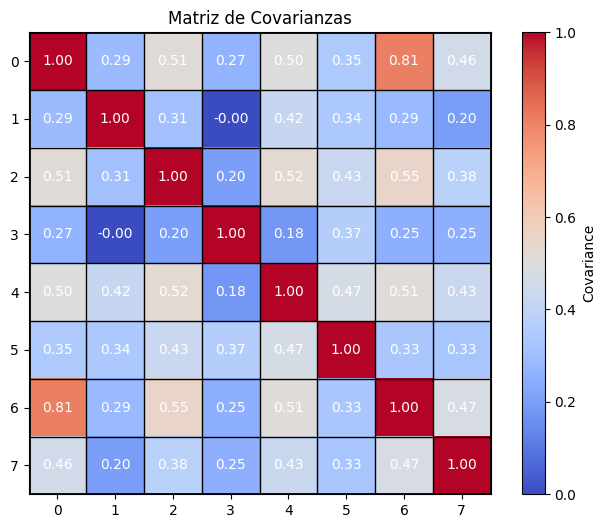

0

In [7]:
dibuja_covar(corr_ret)

Vamos a comparar esta matriz de covarianzas con la que obtendremos con los números aleatorios independientes.

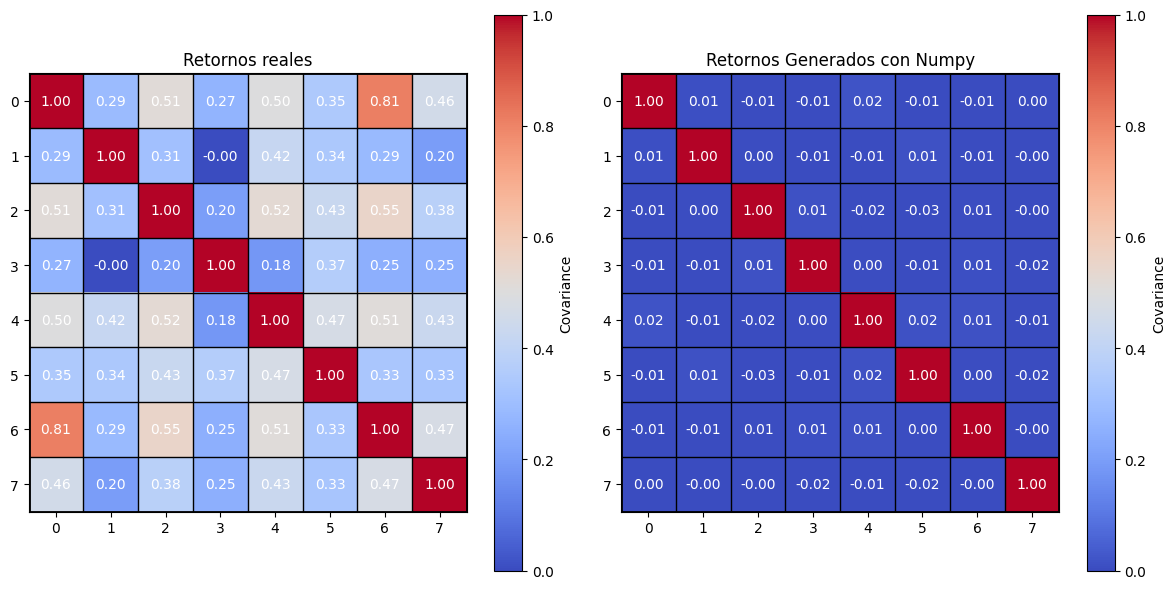

In [8]:
# Crea una figura con dos subgráficos en una fila
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Llama a la función dibuja_covar en el primer subgráfico
dibuja_covar_ax(corr_ret, axs[0])
axs[0].set_title('Retornos reales')

# Llama a la función dibuja_covar en el segundo subgráfico
dibuja_covar_ax(corr_ind, axs[1])
axs[1].set_title('Retornos Generados con Numpy')

# Ajusta el espacio entre los subgráficos
plt.tight_layout()


# Muestra la gráfica con ambos subgráficos
plt.show()

### Segundo paso

Vamos a generar retornos aleatorios que mantengan la estructura de correlación de los retornos reales. Para ello, vamos a usar la descomposición de Cholesky.

1- USAMOS CÓPULA NORMAL

Las distribuciones marginales de los activos son normales y modela la dependencia lineal entre ellos. Es ampliamente utilizada en el modelado de riesgo financiero, pero puede subestimar la cola de eventos extremos.

In [9]:
L = np.linalg.cholesky(cov) # Cholesky decomposition of the covariance matrix of the returns of the assets

samp_norm = samp_ind @ L.T + mu.T # a sample of a normal distribution with mean mu with correlation matrix corr

corr_samp_norm = np.corrcoef(samp_norm, rowvar=False) #Matrix of correlation of the generated sample using the correlation matrix


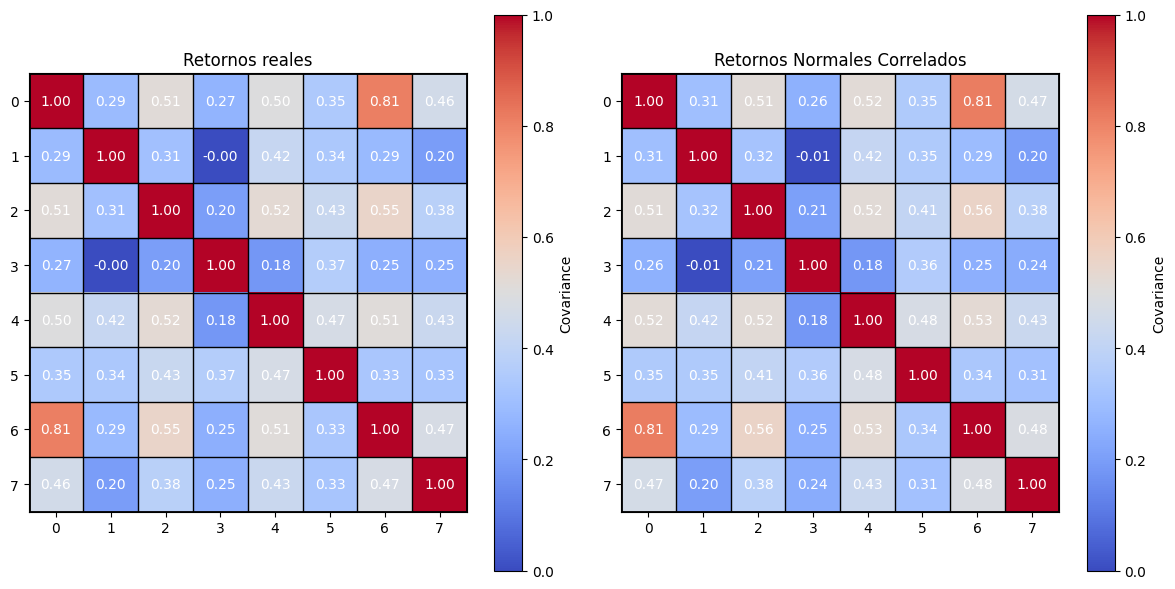

In [10]:
# Crea una figura con dos subgráficos en una fila
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Llama a la función dibuja_covar en el primer subgráfico
dibuja_covar_ax(corr_ret, axs[0])
axs[0].set_title('Retornos reales')

# Llama a la función dibuja_covar en el segundo subgráfico
dibuja_covar_ax(corr_samp_norm, axs[1])
axs[1].set_title('Retornos Normales Correlados')

# Ajusta el espacio entre los subgráficos
plt.tight_layout()


# Muestra la gráfica con ambos subgráficos
plt.show()

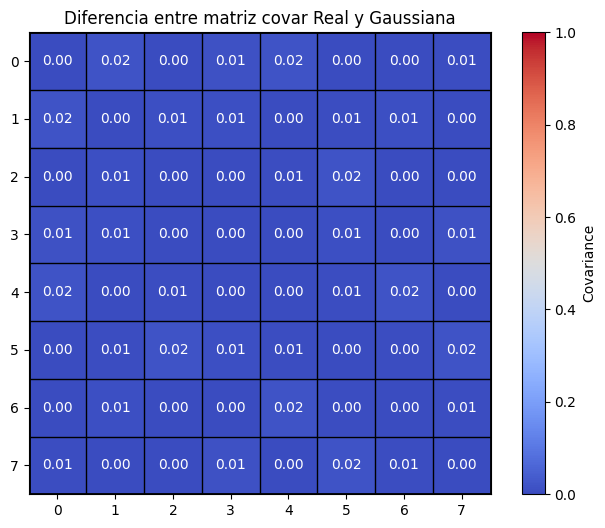

0

In [11]:
cov_diff_norm = np.abs(corr_ret - corr_samp_norm)
dibuja_covar(cov_diff_norm, 'Diferencia entre matriz covar Real y Gaussiana')

2- USAMOS CÓPULA t-Student 

Las distribuciones marginales de los activos son t-Student y modela la dependencia lineal entre ellos. Es ampliamente utilizada en el modelado de riesgo financiero, para tener más en cuenta la cola de eventos extremos.

In [12]:

#A = rs.randn(num_datos, n) # a sample from standard normal distribution

v = (num_datos - 1) * num_act # degree of freedom
V = rs.chisquare(v, size = (num_datos, 1)) # A random sample of chi square variables

#s = np.sqrt(v/V) * (samp_ind @ L.T)
samp_t = np.sqrt(v/V) * (samp_ind @ L.T) + mu.T # Correlated sample assuming a t copula

corr_samp_t = np.corrcoef(samp_t, rowvar=False)

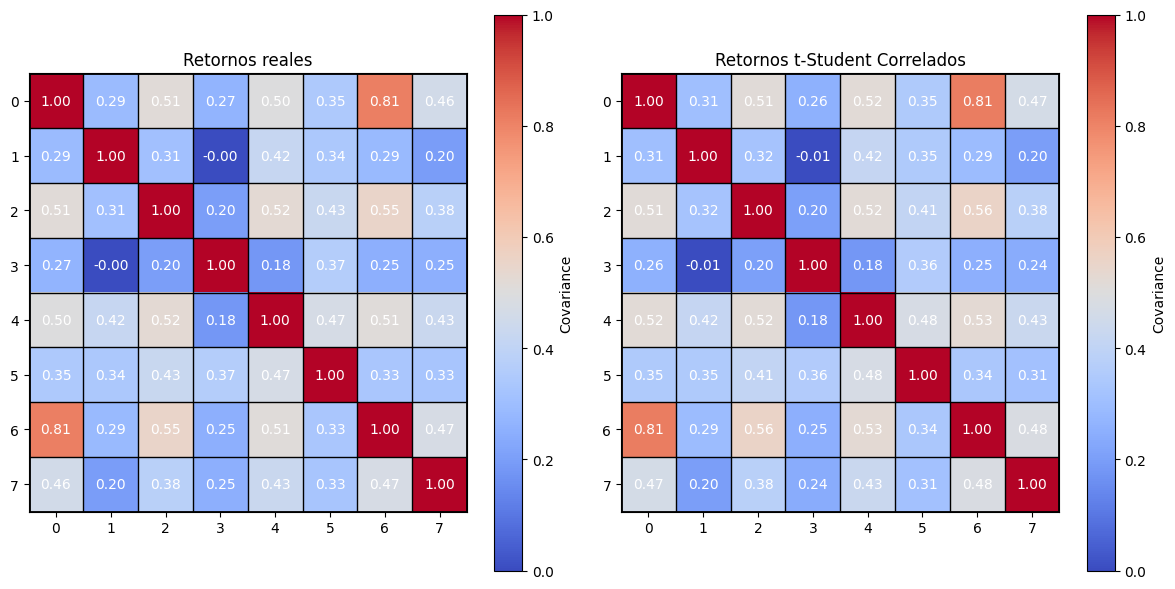

In [13]:
# Crea una figura con dos subgráficos en una fila
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Llama a la función dibuja_covar en el primer subgráfico
dibuja_covar_ax(corr_ret, axs[0])
axs[0].set_title('Retornos reales')

# Llama a la función dibuja_covar en el segundo subgráfico
dibuja_covar_ax(corr_samp_t, axs[1])
axs[1].set_title('Retornos t-Student Correlados')

# Ajusta el espacio entre los subgráficos
plt.tight_layout()


# Muestra la gráfica con ambos subgráficos
plt.show()

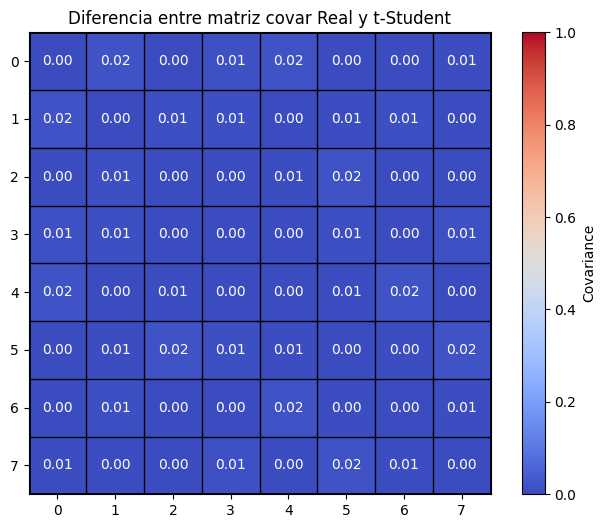

0

In [14]:
cov_diff_t = np.abs(corr_ret - corr_samp_t)
dibuja_covar(cov_diff_t, 'Diferencia entre matriz covar Real y t-Student')

Hasta ahora, no hemos tenido en cuenta las varianzas de cada uno de los activos. Vamos a generar unas variables normales estándar con las correlaciones de los retornos de los activos y, además, vamos a tener en cuenta las varianzas de cada uno de los activos.

In [15]:
samp_norm_std = (samp_ind @ L.T) * std.T + mu.T # multiply by the standard deviation and add the mean

corr_samp_norm_std = np.corrcoef(samp_norm_std, rowvar=False)

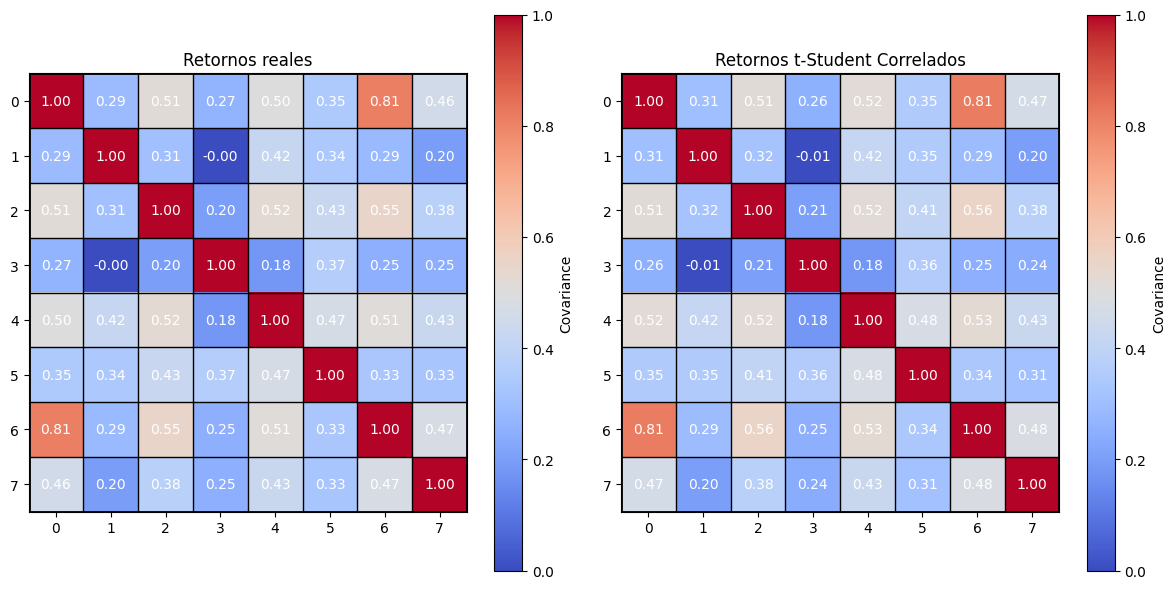

In [16]:
# Crea una figura con dos subgráficos en una fila
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Llama a la función dibuja_covar en el primer subgráfico
dibuja_covar_ax(corr_ret, axs[0])
axs[0].set_title('Retornos reales')

# Llama a la función dibuja_covar en el segundo subgráfico
dibuja_covar_ax(corr_samp_norm_std, axs[1])
axs[1].set_title('Retornos t-Student Correlados')

# Ajusta el espacio entre los subgráficos
plt.tight_layout()


# Muestra la gráfica con ambos subgráficos
plt.show()

## GENERACIÓN DE NÚMEROS ALEATORIOS CADA UNO CON UNA DISTRIBUCIÓN DISTINTA

Vamos a generar muestras que sigan distintas distribuciones de probabilidad utilizando la **Transformación Integral de Probabilidad**.
 
La **Transformación Integral de Probabilidad** es un concepto en estadísticas que establece que si tenemos una variable aleatoria continua $X$ con una función de densidad de probabilidad $f(X)$ y una variable aleatoria $U$ que sigue una distribución uniforme en el intervalo $[0, 1]$, entonces la variable aleatoria $Y$ definida como:
$$Y = F^{⁻1}(U)$$
donde $F^{⁻1}$ es la función inversa de la función de distribución acumulada (CDF) $F(X)$, entonces la variable aleatoria $Y$ sigue la misma distribución que la variable aleatoria $X$.

Los pasos a seguir son:

- Generamos números aleatorios de distribución uniforme entre 0 y 1 que serán las probabilidades de cada uno de los valores de la distribución de probabilidad que queremos generar

- Utilizando la función ppf (que es la inversa de la CDF) de la librería scipy.stats, generamos los valores de la variable con distribución de probabilidad que queremos generar

In [22]:
X = rs.rand(num_datos) # num_datos samples of random vector with uniform distribution

# Generamos muestras de una distribución normal, t-Student y Laplace
distr_pdf = pd.DataFrame({'Normal': stats.norm.ppf(X, loc=0, scale=1), 't-Student': stats.t.ppf(X, df=3, loc=0, scale=1), 'Laplace': stats.laplace.ppf(X, loc=0, scale=1)})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


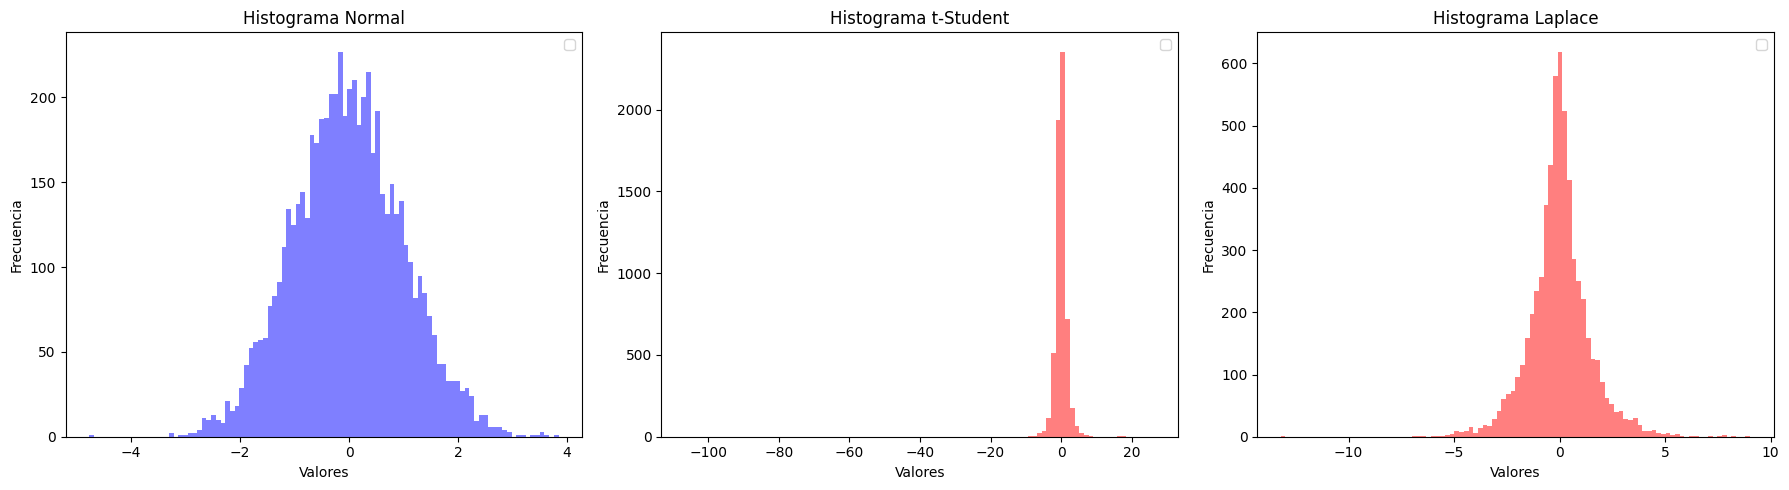

In [18]:
# Crear subplots con tres gráficas en una fila
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Primer histograma en el primer subplot
axs[0].hist(distr_pdf['Normal'], bins=100, alpha=0.5, color='blue')
axs[0].set_xlabel('Valores')
axs[0].set_ylabel('Frecuencia')
axs[0].legend(loc='upper right')
axs[0].set_title('Histograma Normal')

# Segundo histograma en el segundo subplot
axs[1].hist(distr_pdf['t-Student'], bins=100, alpha=0.5, color='red')
axs[1].set_xlabel('Valores')
axs[1].set_ylabel('Frecuencia')
axs[1].legend(loc='upper right')
axs[1].set_title('Histograma t-Student')

# Tercer histograma en el segundo subplot
axs[2].hist(distr_pdf['Laplace'], bins=100, alpha=0.5, color='red')
axs[2].set_xlabel('Valores')
axs[2].set_ylabel('Frecuencia')
axs[2].legend(loc='upper right')
axs[2].set_title('Histograma Laplace')

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()


Pero las correlaciones entre activos son muy altas ya que usamos la misma muestra de probabilidades X.


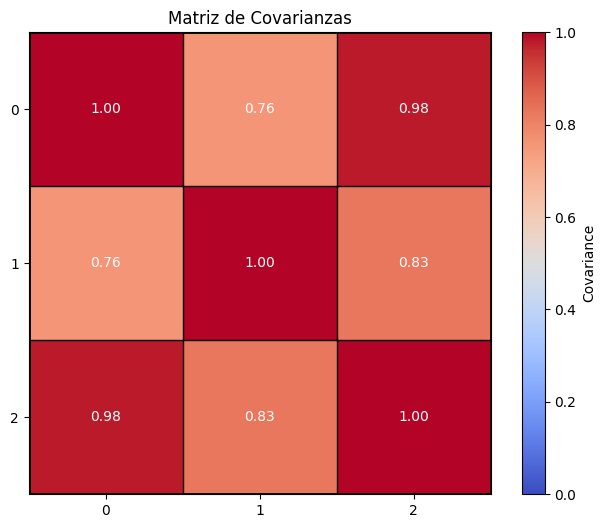

0

In [19]:
tmp_covar = np.corrcoef(distr_pdf, rowvar=False)
dibuja_covar(tmp_covar)

¿Qué ocurre si generaramos una muestra de probabilidades X para cada distribución?. 

Que las muestras de probabilidades X serían distintas e independientes y por lo tanto las correlaciones entre activos serán 0.

In [20]:
X1 = rs.rand(num_datos) # num_datos samples of random vector with uniform distribution
X2 = rs.rand(num_datos) # num_datos samples of random vector with uniform distribution
X3 = rs.rand(num_datos) # num_datos samples of random vector with uniform distribution

# Generamos muestras de una distribución normal, t-Student y Laplace
distr_pdf = pd.DataFrame({'Normal': stats.norm.ppf(X1, loc=0, scale=1), 't-Student': stats.t.ppf(X2, df=3, loc=0, scale=1), 'Laplace': stats.laplace.ppf(X3, loc=0, scale=1)})

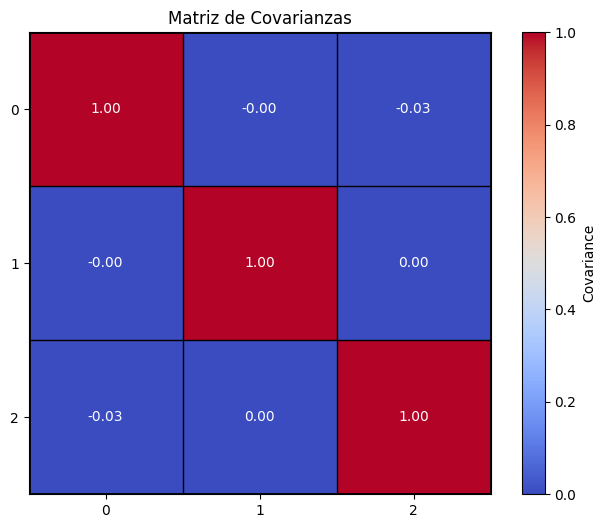

0

In [21]:
tmp_covar = np.corrcoef(distr_pdf, rowvar=False)
dibuja_covar(tmp_covar)

## GENERACIÓN ALEATORIOS CON DISTRIBUCIÓN DE PROBABILIDAD CONCRETA Y CON CORRELACIONES

Los pasos a realizar son los siguientes:

1- Calculamos las distribución de cada activo y las relaciones entre ellos

2- Generamos una muestra de retornos con las correlaciones de los activos 

3- Calculamos las probabilidades de cada uno de los valores usando la CDF de la distribución de probabilidad usada en el punto anterior

4- Generamos las muestra de cada activo usando la ppf de cada acivo y las probabilidades calculadas en el punto anterior

PUNTO 1: DISTRIBUCIÓN DE CADA ACTIVO Y RELACIONES ENTRE ELLOS

Definimos una función que, dados los retornos de un activo, nos devuelve la distribución de probabilidad que más se ajusta a los retornos de ese activo.

In [4]:
def get_best_distribution(data):
    """
    Función que calcula la mejor distribución para un conjunto de datos de entre una lista de distribuciones usando el test de Kolmogorov-Smirnov
    """

    dist_names = ["norm", "t", "laplace"]
    dist_results = []
    params = {}

    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(data)
        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        dist_results.append((dist_name, p))
    # select the best fitted distribution
    print(dist_results)
    print(params)
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))

    return best_dist, best_p, params[best_dist]

Calculo la mejor distribución y los parámetros de la distribución que mejor se ajusta a los retornos de cada activo.

In [7]:
dist_type = []
p_value = []
dist_params = []

for i in range(num_act):
    dist_tmp, p_tmp, params_tmp = get_best_distribution(ret[assets[i]])
    dist_type.append(dist_tmp)
    p_value.append(p_tmp)
    dist_params.append(params_tmp)
    
distrib_pdf =pd.DataFrame({'Distribución': dist_type, 'p-value': p_value, 'Parámetros': dist_params}, index=assets)

[('norm', 0.01041382559226629), ('t', 0.9223519098509858), ('laplace', 0.13067683641525696)]
{'norm': (0.0010609386558503222, 0.02323427556856433), 't': (4.18258721460759, 0.0011272677137213593, 0.016936958977469614), 'laplace': (0.0006617111369364714, 0.016654585445532277)}
[('norm', 5.824697030770807e-06), ('t', 0.7462317670819945), ('laplace', 0.2332693726083933)]
{'norm': (0.0023939403803664595, 0.05338026913837523), 't': (3.107761445792482, 0.0013992608038560124, 0.031874938558194274), 'laplace': (0.00138429705099119, 0.03481193470974263)}
[('norm', 0.00010050948868534345), ('t', 0.9268948176789997), ('laplace', 0.30231203052594113)]
{'norm': (-5.632544344757372e-05, 0.01971175945333979), 't': (3.186466957750423, 0.0006479015041644075, 0.012829640159168935), 'laplace': (0.0005880754440068525, 0.013704256131271455)}
[('norm', 2.168438039654469e-05), ('t', 0.7028615075607975), ('laplace', 0.23792179886994613)]
{'norm': (0.00044870327364180263, 0.016609480840806035), 't': (3.27671591

El DataFrame distrib_pdf contiene la distribución de probabilidad de cada activo y los parámetros de la distribución que mejor se ajusta a los retornos de cada activo:

- En el caso de la t_student, el primer parámetro es el número de grados de libertad, el segundo parámetro es la media y el tercer parámetro es la desviación estándar.

In [8]:
distrib_pdf

,Distribución,p-value,Parámetros
AAPL,t,0.922352,"(4.18258721460759, 0.0011272677137213593, 0.01..."
APA,t,0.746232,"(3.107761445792482, 0.0013992608038560124, 0.0..."
CMCSA,t,0.926895,"(3.186466957750423, 0.0006479015041644075, 0.0..."
CPB,t,0.702862,"(3.2767159105982175, 0.0008258473853629338, 0...."
JCI,t,0.940777,"(3.909288638721135, 0.0014435288370867963, 0.0..."
MO,t,0.821267,"(2.763398053322657, 0.0014020583142817157, 0.0..."
MSFT,t,0.873348,"(3.6270285497008867, 0.0010002660798371617, 0...."
TGT,t,0.988899,"(2.7648693117410774, 0.0007817810594347308, 0...."


Las estadísticas y correlacioens entre activos son:

In [9]:
# Calculate statistics of daily returns
mu = ret.mean().to_numpy().reshape(-1,1) # mean vector
cov = ret.cov().to_numpy() # covariance matrix
corr = ret.corr().to_numpy() # correlation matrix
std = np.diag(cov).reshape(-1,1) # standard deviation vector
skew = ret.skew()
kurt = ret.kurt()

corr_ret = np.corrcoef(ret, rowvar=False) #Matrix of correlation of the returns

PUNTO 2: GENERAMOS UNA MUESTRA CON LAS CORRELACIONES DE LOS ACTIVOS

Utilizamos la cópula normal para generar una muestra de números aleatorios que sigan la estructura de correlación de los activos.

In [11]:
samp_ind = rs.randn(num_datos, num_act)

L = np.linalg.cholesky(cov) # Cholesky decomposition of the covariance matrix of the returns of the assets

samp_norm = (samp_ind @ L.T) * std.T  + mu.T # a sample of a normal distribution with mean mu with correlation matrix corr

corr_samp_norm = np.corrcoef(samp_norm, rowvar=False) #Matrix of correlation of the generated sample using the correlation matrix

PUNTO 3: CALCULAMOS LAS PROBABLIDADES DE CADA UNO DE LOS VALORES USANDO LA CDF DE LAS DISTRIBUCIONES CALCULADAS EN EL PUNTO 1

In [33]:
prob_samples = pd.DataFrame()
for i in range(num_act):
    if distrib_pdf.iloc[i]['Distribución'] == 'norm':
        prob_samples[i] = stats.norm.cdf(ret.iloc[:, 0], loc=distrib_pdf.iloc[i]['Parámetros'][1], scale=distrib_pdf.iloc[i]['Parámetros'][2])
    elif distrib_pdf.iloc[i]['Distribución'] == 't':
        prob_samples[i] = stats.t.cdf(ret.iloc[:, 0], distrib_pdf.iloc[i]['Parámetros'][0], loc=distrib_pdf.iloc[i]['Parámetros'][1], scale=distrib_pdf.iloc[i]['Parámetros'][2])
    elif distrib_pdf.iloc[i]['Distribución'] == 'laplace':
        prob_samples[i] = stats.laplace.cdf(ret.iloc[:, 0], loc=distrib_pdf.iloc[i]['Parámetros'][1], scale=distrib_pdf.iloc[i]['Parámetros'][2])

PUNTO 4: GENERAMOS LAS MUESTRAS DE CADA ACTIVO USANDO LA PPF DE CADA ACTIVO Y LAS PROBABILIDADES DEL PUNTO ANTERIOR

In [76]:
np.mean(ret['CMCSA'])

-5.632568194423999e-05

In [77]:
np.std(ret['CMCSA'])

0.019711752237144015

In [66]:
# Get the probability associated to each column
cdf_sample = np.zeros_like(corr_sample)
for i in range(n):
    cdf_sample[:, i] = st.norm.cdf(corr_sample[:, i], loc=mu[i], scale=std[i])

/tmp/ipykernel_34806/3291124776.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type(distrib_pdf['Parámetros'][0])


tuple

## BORRAR ENTRE ESTE PUNTO Y EL SIGUIENTE

In [47]:
import statsmodels.api as sm

In [59]:
cdf_ret_tmp = pd.DataFrame()
cdf_ret_tmp['ret'] = ret['AAPL'].sort_values()
cdf_ret_tmp['cdf'] = (range(cdf_ret_tmp.shape[0]))
cdf_ret_tmp['cdf'] = (cdf_ret_tmp['cdf'] +1) / cdf_ret_tmp.shape[0]


In [60]:
cdf_ret_tmp

,ret,cdf
Date,,
2020-03-16,-0.128647,0.001321
2020-03-12,-0.098755,0.002642
2020-09-03,-0.080061,0.003963
2020-03-09,-0.079092,0.005284
2020-09-08,-0.067295,0.006605
...,...,...
2022-11-10,0.088974,0.994716
2020-03-02,0.093101,0.996037
2020-03-24,0.100325,0.997358


In [61]:
# Ajusta un modelo de regresión lineal polinómica
grado = 5  # Grado del polinomio, ajusta según sea necesario
X_tmp = np.vander(ret['AAPL'], grado + 1)  # Matriz de diseño polinómico
modelo = sm.OLS(cdf_ret_tmp['cdf'], X_tmp).fit()

In [62]:
# Obtén las predicciones del modelo
predicciones = modelo.predict()

# Calcula el error cuadrático medio (MSE)
mse = np.mean((ret['AAPL'] - predicciones)**2)

# Calcula el error absoluto medio (MAE)
mae = np.mean(np.abs(ret['AAPL'] - predicciones))

print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")

Error Cuadrático Medio (MSE): 0.25
Error Absoluto Medio (MAE): 0.50


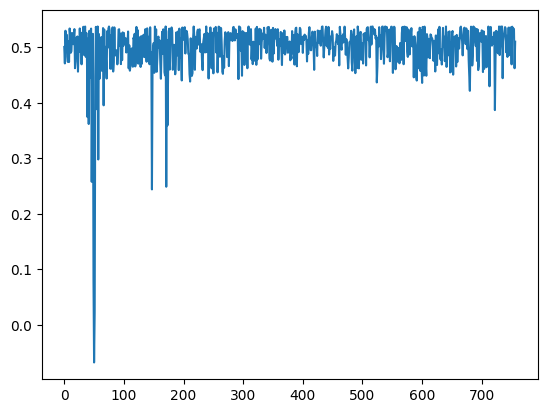

In [64]:
plt.plot(predicciones)

## BORRAR ENTRE ESTE PUNTO Y EL AN

In [23]:
# Calculate statistics of daily returns
mu = ret.mean().to_numpy().reshape(-1,1) # mean vector
cov = ret.cov().to_numpy() # covariance matrix
corr = ret.corr().to_numpy() # correlation matrix
skew = ret.skew()
kurt = ret.kurt()

corr_ret = np.corrcoef(ret, rowvar=False) #Matrix of correlation of the returns

dibuja_covar(corr_ret)

PUNTO 2: GENERACIÓN DE MUESTRA DE RETORNOS CON LAS CORRELACIONES DE LOS ACTIVOS

Usamos la distribución normal estándar para generar los retornos de cada uno de los activos

In [31]:
L = np.linalg.cholesky(cov) # Cholesky decomposition of the covariance matrix of the returns of the assets

samp_norm = (samp_ind @ L.T + mu.T) * std.T # a sample of a normal distribution with mean mu with correlation matrix corr

corr_samp_norm = np.corrcoef(samp_norm, rowvar=False) #Matrix of correlation of the generated sample using the correlation matrix

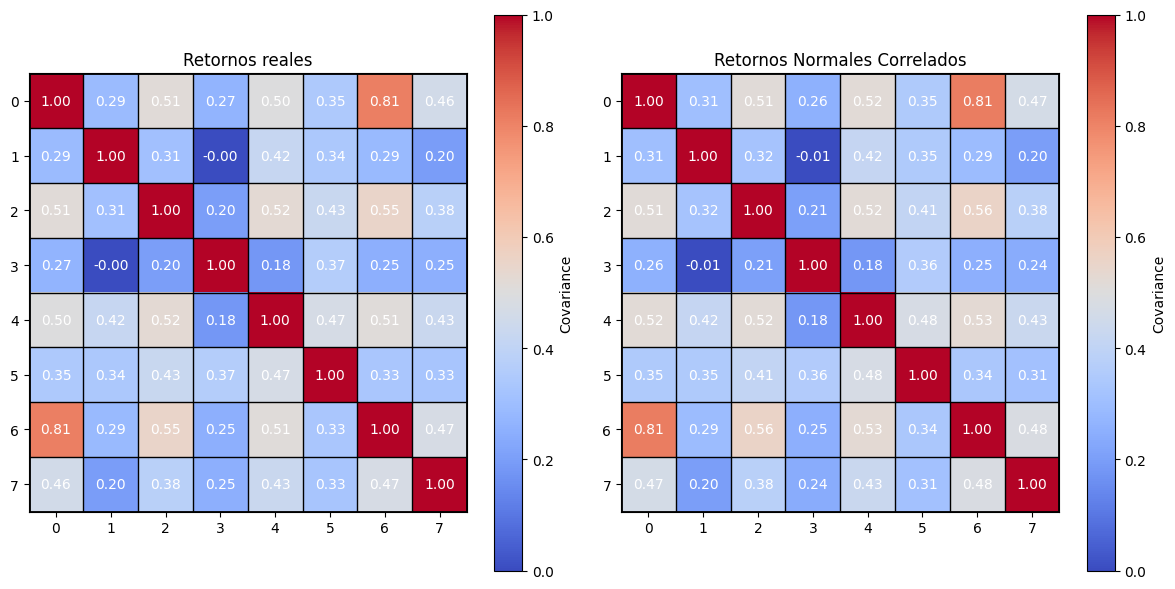

In [32]:
# Crea una figura con dos subgráficos en una fila
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Llama a la función dibuja_covar en el primer subgráfico
dibuja_covar_ax(corr_ret, axs[0])
axs[0].set_title('Retornos reales')

# Llama a la función dibuja_covar en el segundo subgráfico
dibuja_covar_ax(corr_samp_norm, axs[1])
axs[1].set_title('Retornos Normales Correlados')

# Ajusta el espacio entre los subgráficos
plt.tight_layout()


# Muestra la gráfica con ambos subgráficos
plt.show()

PUNTOS 3 Y 4: GENERACIÓN DE MUESTRA DE CADA ACTIVO CON LA DISTRIBUCIÓN DE PROBABILIDAD CONCRETA Y CON LAS CORRELACIONES DE LOS ACTIVOS

NOTA: CÓMO VARÍA LA DISTRIBUCIÓN t-sTUDENT CON LOS GRADOS DE LIBERTAD:

Generamos una distribución t-student con 1, 5 y 10 grados de libertad y las grafico. Vemos que a medida que aumentan los grados de libertad, la distribución se parece más a una distribución normal estándar.

In [25]:
sample_t1 = stats.t.ppf(X, df=1, loc=0, scale=1) 
sample_t5 = stats.t.ppf(X, df=5, loc=0, scale=1)
sample_t10 = stats.t.ppf(X, df=10, loc=0, scale=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


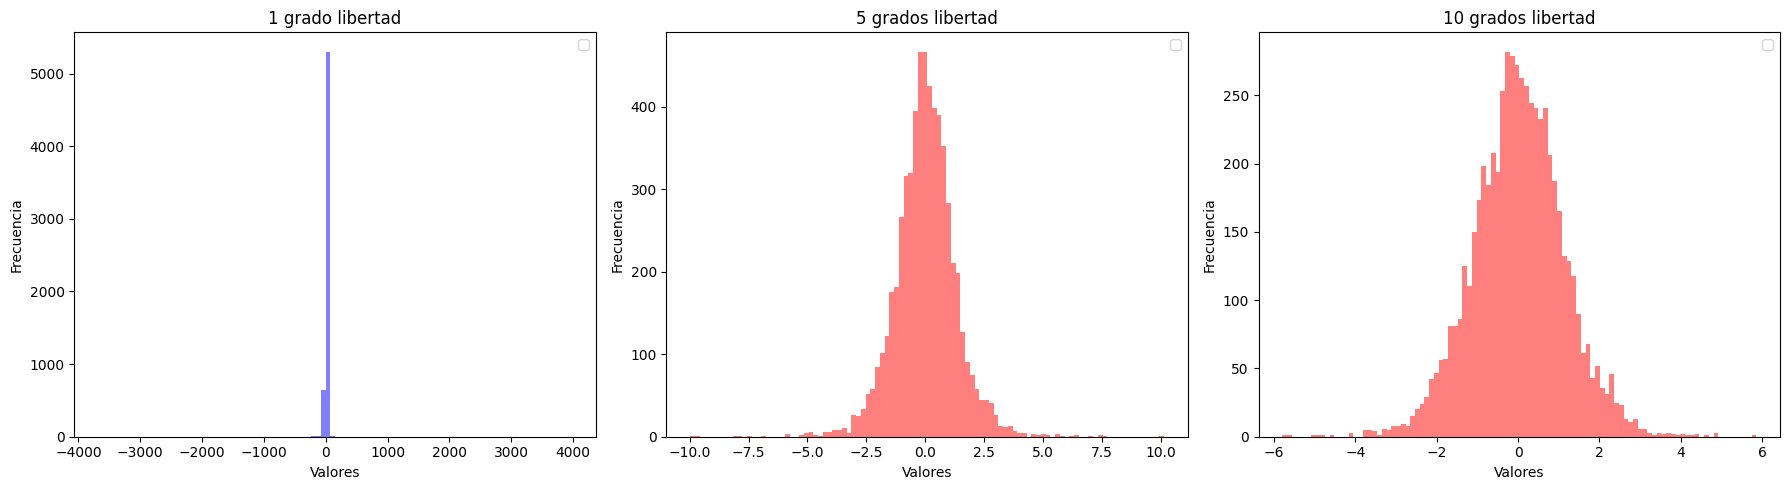

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Primer histograma en el primer subplot
axs[0].hist(sample_t1, bins=100, alpha=0.5, color='blue')
axs[0].set_xlabel('Valores')
axs[0].set_ylabel('Frecuencia')
axs[0].legend(loc='upper right')
axs[0].set_title('1 grado libertad')

# Segundo histograma en el segundo subplot
axs[1].hist(sample_t5, bins=100, alpha=0.5, color='red')
axs[1].set_xlabel('Valores')
axs[1].set_ylabel('Frecuencia')
axs[1].legend(loc='upper right')
axs[1].set_title('5 grados libertad')

# Segundo histograma en el segundo subplot
axs[2].hist(sample_t10, bins=100, alpha=0.5, color='red')
axs[2].set_xlabel('Valores')
axs[2].set_ylabel('Frecuencia')
axs[2].legend(loc='upper right')
axs[2].set_title('10 grados libertad')

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()